In [265]:
import numpy as np
import pandas as pd
import matplotlib as plt
import geopandas as gpd # conda install geopandas
from geopandas.tools import sjoin
import shapely
from shapely.geometry import Point, Polygon
import folium # conda install -c conda-forge folium
import json
import pickle
import geopy
from geopy.extra.rate_limiter import RateLimiter
import re
import requests
import functools
import matplotlib.pyplot as plt

### Import data
We import the dataset containing the food inspection and drop all irrelevant and null columns.

In [266]:
data = pd.read_csv('data/food-inspections.csv').drop(['AKA Name', 'City', 'State', "Historical Wards 2003-2015", "Zip Codes", "Community Areas", "Census Tracts", "Wards", "Location"], axis=1)
data.head()

,Inspection ID,DBA Name,License #,Facility Type,Risk,Address,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude
0,2320509,TAQUERIA EL DORADO,2694960.0,Restaurant,Risk 1 (High),2114 W LAWRENCE AVE,60625.0,2019-10-25T00:00:00.000,License Re-Inspection,Fail,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.968820,-87.682292
1,2320519,SALAM RESTAURANT,2002822.0,Restaurant,Risk 1 (High),4634-4636 N KEDZIE AVE,60625.0,2019-10-25T00:00:00.000,Complaint Re-Inspection,Pass,NaN,41.965719,-87.708538
2,2320421,THE NEW GRACE RESTAURANT,2698310.0,Restaurant,Risk 1 (High),4409 N BROADWAY,60640.0,2019-10-24T00:00:00.000,License,Not Ready,NaN,41.962104,-87.655204
3,2320368,GADS HILL CHILD CARE CENTER,2215799.0,Children's Services Facility,Risk 1 (High),2653 W OGDEN AVE,60608.0,2019-10-24T00:00:00.000,License,Pass,10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLI...,41.862273,-87.692703
4,2320389,"ALL THINGS ARE POSSIBLE FOR KIDS, INC.",2215965.0,Children's Services Facility,Risk 1 (High),4014 W CHICAGO AVE,60651.0,2019-10-24T00:00:00.000,License,Pass,54. GARBAGE & REFUSE PROPERLY DISPOSED; FACILI...,41.895468,-87.726665


# Complete the dataset

## Duplicates


Entries must be identified by their Inspection ID. However, we can find some duplicated Inspection Ids with exactly the same report.

In [267]:
data[data.duplicated("Inspection ID", keep=False)].sort_values(by=["Inspection ID"]).head(6)

,Inspection ID,DBA Name,License #,Facility Type,Risk,Address,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude
159968,509435,PARISIS DRIVE IN,3523.0,Restaurant,Risk 1 (High),6216 W 63RD ST,60638.0,2011-11-18T00:00:00.000,Canvass,Fail,24. DISH WASHING FACILITIES: PROPERLY DESIGNED...,41.777863,-87.777177
160020,509435,PARISIS DRIVE IN,3523.0,Restaurant,Risk 1 (High),6216 W 63RD ST,60638.0,2011-11-18T00:00:00.000,Canvass,Fail,24. DISH WASHING FACILITIES: PROPERLY DESIGNED...,41.777863,-87.777177
159950,519324,TASTE OF LEBANON,57633.0,Restaurant,Risk 1 (High),1509 W FOSTER AVE,60640.0,2011-11-18T00:00:00.000,Canvass Re-Inspection,Pass,"34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...",41.976075,-87.668743
160026,519324,TASTE OF LEBANON,57633.0,Restaurant,Risk 1 (High),1509 W FOSTER AVE,60640.0,2011-11-18T00:00:00.000,Canvass Re-Inspection,Pass,"34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...",41.976075,-87.668743
159945,519325,THRIFTY FOOD,1045545.0,Grocery Store,Risk 2 (Medium),928 W WILSON AVE,60640.0,2011-11-18T00:00:00.000,Canvass Re-Inspection,Pass,38. VENTILATION: ROOMS AND EQUIPMENT VENTED AS...,41.965558,-87.653559
160010,519325,THRIFTY FOOD,1045545.0,Grocery Store,Risk 2 (Medium),928 W WILSON AVE,60640.0,2011-11-18T00:00:00.000,Canvass Re-Inspection,Pass,38. VENTILATION: ROOMS AND EQUIPMENT VENTED AS...,41.965558,-87.653559


This duplicated rows can simply be removed.

In [268]:
print("Number of duplicate inspection IDs: " + str(len(data[data.duplicated("Inspection ID")])))
data = data.drop_duplicates()
print("Number of duplicate inspection IDs after removal: " + str(len(data[data.duplicated()])))

Number of duplicate inspection IDs: 196
Number of duplicate inspection IDs after removal: 0


## Deal with missing values

Let's first plot the number of missing values per feature

In [73]:
for col in data.columns:
    print("Number of null entries for " + col + ": " + str(len(data[data[col].apply(pd.isnull)])))
for col in data.columns:
    if isinstance(data[col][0], str):
        print("Number of empty string entries for " + col + ": " + str(len(data[data[col].apply(str).apply(str.isspace)])))

Number of null entries for Inspection ID: 0
Number of null entries for DBA Name: 0
Number of null entries for License #: 17
Number of null entries for Facility Type: 4770
Number of null entries for Risk: 72
Number of null entries for Address: 0
Number of null entries for Zip: 50
Number of null entries for Inspection Date: 0
Number of null entries for Inspection Type: 1
Number of null entries for Results: 0
Number of null entries for Violations: 51636
Number of null entries for Latitude: 682
Number of null entries for Longitude: 682
Number of empty string entries for DBA Name: 0
Number of empty string entries for Facility Type: 0
Number of empty string entries for Risk: 0
Number of empty string entries for Address: 3
Number of empty string entries for Inspection Date: 0
Number of empty string entries for Inspection Type: 0
Number of empty string entries for Results: 0
Number of empty string entries for Violations: 0


### Address
There are some addresses that are missing in that they only contain a few spaces.

In [74]:
data[data['Address'].apply(str.isspace)]

,Inspection ID,DBA Name,License #,Facility Type,Risk,Address,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude
69601,1763245,EAT N RUN CHICKEN AND FISH,2442868.0,Restaurant,Risk 1 (High),,NaN,2016-04-19T00:00:00.000,License,Not Ready,NaN,NaN,NaN
189113,114452,Starfruit Cafe,2031651.0,NaN,Risk 2 (Medium),,60654.0,2010-05-05T00:00:00.000,License,Fail,NaN,NaN,NaN
190589,60405,CASA CENTRAL LA POSADA,0.0,Restaurant,Risk 1 (High),,NaN,2010-04-05T00:00:00.000,Canvass,Pass,37. TOILET ROOM DOORS SELF CLOSING: DRESSING R...,NaN,NaN


We will manually complete the addresses for the establishments that we can find:

In [75]:
data.loc[data["Inspection ID"]==1763245, "Address"] = "8233 S ASHLAND AVE"
data.loc[data["Inspection ID"]==60405, "Address"] = "3209 W EVERGREEN AVE"

In [76]:
data[data['Address'].apply(str.isspace)]

,Inspection ID,DBA Name,License #,Facility Type,Risk,Address,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude
189113,114452,Starfruit Cafe,2031651.0,NaN,Risk 2 (Medium),,60654.0,2010-05-05T00:00:00.000,License,Fail,NaN,NaN,NaN


### Latitude and longitude
There are entries that are missing coordinate data, which is needed to put them on the map.
We see that all entries have address data, so we try to fill in the null values for the coordinates by using Geopy that uses geocoders to get coordinates based on addresses. Through testing we found that using ArcGIS as a geocoder gives us a perfect result.

In [ ]:
locator = geopy.geocoders.ArcGIS(user_agent='myGeocoder')
data_wo_latlong = data[data['Latitude'].apply(np.isnan)].groupby("DBA Name").first()
geocode = RateLimiter(locator.geocode, min_delay_seconds=2)
lats = pd.Series(index=data_wo_latlong.index)
longs = pd.Series(index=data_wo_latlong.index)
for name, address in list(zip(data_wo_latlong.index, data_wo_latlong['Address'])):
    if str.isspace(address):
        print('Empty address for ' + name + ' ignored')
        continue
    location = geocode(address + ", Chicago, United States")
    if location is not None:
        lats[name] = location.latitude
        longs[name] = location.longitude
    else:
        print('Did not find location for address: ' + address)

for name, lat, long in zip(lats.index, lats, longs):
    data['Latitude'] = np.where(data['DBA Name'] == name, lat, data['Latitude'])
    data['Longitude'] = np.where(data['DBA Name'] == name, long, data['Longitude'])

In [11]:
print("Number of entries without coordinate data: " + str(len(data[data["Latitude"].apply(pd.isnull)])))
data[data["Latitude"].apply(pd.isnull)]

Number of entries without coordinate data: 682


,Inspection ID,DBA Name,License #,Facility Type,Risk,Address,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude
510,2315463,VEENO,2578370.0,Restaurant,Risk 2 (Medium),2009 S LAFIN ST,60608.0,2019-10-08T00:00:00.000,License,Fail,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",NaN,NaN
534,2315467,VEENO,2578371.0,Restaurant,Risk 3 (Low),2009 S LAFIN ST,60608.0,2019-10-08T00:00:00.000,License,Fail,NaN,NaN,NaN
1317,2312470,Carson (Old),22601.0,School,Risk 1 (High),5516 S Maplewood (2532W) AVE,60629.0,2019-09-18T00:00:00.000,Canvass Re-Inspection,Pass,"55. PHYSICAL FACILITIES INSTALLED, MAINTAINED ...",NaN,NaN
1419,2312360,"PACINO'S RC, LLC",2683669.0,Restaurant,Risk 3 (Low),1010 S DELANO CT,60605.0,2019-09-16T00:00:00.000,License Re-Inspection,Pass,NaN,NaN,NaN
1472,2312357,"PACINO'S RC, LLC",2683667.0,Restaurant,Risk 1 (High),1010 S DELANO CT,60605.0,2019-09-16T00:00:00.000,License Re-Inspection,Pass,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
194538,67840,TONTI ELEMENTARY,25631.0,School,Risk 1 (High),5815 S Homan (3400W) AVE,60629.0,2010-01-12T00:00:00.000,Canvass,Pass,"34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...",NaN,NaN
194624,158253,ARGENTINA FOODS,2009367.0,Grocery Store,Risk 2 (Medium),4500 S WOODS ST,60609.0,2010-01-11T00:00:00.000,License,Fail,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,NaN,NaN
194704,154225,Chartwells,1166638.0,Special Event,Risk 2 (Medium),2324 N FREMONT ST,60614.0,2010-01-07T00:00:00.000,Canvass,Pass,33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSI...,NaN,NaN
194713,67788,Carson (Old),22601.0,School,Risk 1 (High),5516 S Maplewood (2532W) AVE,60629.0,2010-01-07T00:00:00.000,Canvass,Pass,"30. FOOD IN ORIGINAL CONTAINER, PROPERLY LABEL...",NaN,NaN


### Zip
We supplement the zip codes by finding where the coordinates belong in a GeoJSON boundary map for zip codes.

In [77]:
data[data['Zip'].apply(pd.isnull)].sample(6)

,Inspection ID,DBA Name,License #,Facility Type,Risk,Address,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude
1061,2312774,CHICAGO COLLEGIATE CHARTER,3846104.0,School,Risk 1 (High),10909 S COTTAGE GROVE AVE,NaN,2019-09-24T00:00:00.000,Canvass Re-Inspection,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.696087,-87.608945
173570,525253,THE LUNCH MACHINE INC,2079077.0,Mobile Food Dispenser,Risk 2 (Medium),1319 W WILSON AVE,NaN,2011-03-11T00:00:00.000,License Re-Inspection,Pass,NaN,41.965212,-87.663260
120752,1375435,N AND A FOOD MART INC,1980101.0,Grocery Store,Risk 3 (Low),433 E 79TH STREET,NaN,2013-11-14T00:00:00.000,Canvass,Out of Business,NaN,41.751030,-87.613649
179803,335363,TISH'S TINY TOWN FOR TOTS CHI,1887746.0,NaN,Risk 1 (High),2301 E 79TH ST,NaN,2010-10-25T00:00:00.000,License,Fail,NaN,41.751592,-87.568606
190589,60405,CASA CENTRAL LA POSADA,0.0,Restaurant,Risk 1 (High),3209 W EVERGREEN AVE,NaN,2010-04-05T00:00:00.000,Canvass,Pass,37. TOILET ROOM DOORS SELF CLOSING: DRESSING R...,NaN,NaN
94047,1523196,BURGER KING #1310,2232344.0,Restaurant,Risk 2 (Medium),2320-2322 S MICHIGAN AVE,NaN,2015-02-23T00:00:00.000,Canvass,Out of Business,NaN,41.850454,-87.623891


In [78]:
map_zip = gpd.read_file('data/chicago_zip.geojson')
missing_zip = data[data['Zip'].apply(pd.isnull)].copy()
for index, lat, long in zip(missing_zip.index, missing_zip['Latitude'], missing_zip['Longitude']):
    for zip_code, mpoly in zip(map_zip.zip, map_zip.geometry): 
        for poly in mpoly:
            if poly.contains(Point(long,lat)): # Points in polygons have inverse lat, long
                missing_zip.at[index,'Zip'] = zip_code
data.update(missing_zip)

print("Number of entries without zip data: " + str(len(data[data['Zip'].apply(pd.isnull)])))
data[data['Zip'].apply(pd.isnull)]

Number of entries without zip data: 3


,Inspection ID,DBA Name,License #,Facility Type,Risk,Address,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude
69601,1763245.0,EAT N RUN CHICKEN AND FISH,2442868.0,Restaurant,Risk 1 (High),8233 S ASHLAND AVE,NaN,2016-04-19T00:00:00.000,License,Not Ready,NaN,NaN,NaN
123931,1106878.0,FILIPINO AMERICAN COUNCIL,2225427.0,Golden Diner,Risk 1 (High),1332 W DRIVING PARK ROAD BSMT,NaN,2013-09-26T00:00:00.000,Canvass,Out of Business,NaN,NaN,NaN
190589,60405.0,CASA CENTRAL LA POSADA,0.0,Restaurant,Risk 1 (High),3209 W EVERGREEN AVE,NaN,2010-04-05T00:00:00.000,Canvass,Pass,37. TOILET ROOM DOORS SELF CLOSING: DRESSING R...,NaN,NaN


### License number
We have decided that license numbers are not important for our research. Therefore, we will delete the column.

In [79]:
data.drop(columns=['License #'], inplace=True)

### Facility Type
There are a lot of missing facility types.

In [80]:
null_facility = data[data['Facility Type'].apply(pd.isnull)]
null_facility

,Inspection ID,DBA Name,Facility Type,Risk,Address,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude
137,2316135.0,SHELL,NaN,Risk 3 (Low),6659 S WENTWORTH AVE,60621.0,2019-10-18T00:00:00.000,License,Not Ready,NaN,41.772809,-87.629820
171,2316086.0,UNIVERSITY CENTER PROPERTY LLC,NaN,NaN,525 S STATE ST,60605.0,2019-10-18T00:00:00.000,License,Not Ready,NaN,41.875179,-87.627474
242,2316011.0,DASH OF SALT AND PEPPER,NaN,Risk 1 (High),2201 N LINCOLN AVE,60614.0,2019-10-17T00:00:00.000,License,Not Ready,NaN,41.922056,-87.643811
275,2315957.0,G & J ICE CREAM,NaN,Risk 2 (Medium),6355 S WESTERN AVE,60636.0,2019-10-16T00:00:00.000,License,Not Ready,NaN,41.777509,-87.683450
296,2315960.0,MINGHIN JAPENESE,NaN,NaN,1232-1234 S MICHIGAN AVE,60605.0,2019-10-15T00:00:00.000,License,Not Ready,NaN,41.866541,-87.624281
...,...,...,...,...,...,...,...,...,...,...,...,...
194823,120276.0,BUTTER,NaN,Risk 3 (Low),130 S GREEN ST,60607.0,2010-01-06T00:00:00.000,Out of Business,Pass,NaN,41.879501,-87.648608
194841,160208.0,"LOVEBUGS, TODDLER PROGRAMS AND PRESCHOOL, LLC",NaN,Risk 1 (High),1327 N LARRABEE ST,60610.0,2010-01-05T00:00:00.000,Out of Business,Pass,NaN,41.905866,-87.643136
194861,70272.0,THE DOGHOUSE,NaN,Risk 1 (High),11601 W TOUHY AVE,60666.0,2010-01-05T00:00:00.000,Out of Business,Pass,NaN,42.008536,-87.914428
194862,67760.0,MC INTOSH'S,NaN,Risk 1 (High),748 W 61ST ST,60621.0,2010-01-05T00:00:00.000,Out of Business,Fail,NaN,41.783503,-87.644386


In [81]:
null_facility.groupby('Results').count().rename(columns={"DBA Name": "Count"})["Count"]

Results
Business Not Located      26
Fail                     367
No Entry                  71
Not Ready                 89
Out of Business         3915
Pass                     260
Pass w/ Conditions        42
Name: Count, dtype: int64

For the moment, we will not deal with these missing values, as obtaining the exact facility type is out of the scope and besides, most of the establishments are out of business.

### Risk

In [82]:
null_risk = data[data['Risk'].apply(pd.isnull)]
null_risk

,Inspection ID,DBA Name,Facility Type,Risk,Address,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude
171,2316086.0,UNIVERSITY CENTER PROPERTY LLC,NaN,NaN,525 S STATE ST,60605.0,2019-10-18T00:00:00.000,License,Not Ready,NaN,41.875179,-87.627474
296,2315960.0,MINGHIN JAPENESE,NaN,NaN,1232-1234 S MICHIGAN AVE,60605.0,2019-10-15T00:00:00.000,License,Not Ready,NaN,41.866541,-87.624281
930,2312988.0,COTTAGE GROVE FOOD LLC,NaN,NaN,8207 S COTTAGE GROVE,60619.0,2019-09-26T00:00:00.000,License,No Entry,NaN,41.745539,-87.604930
1300,2312532.0,CHICAGO MERCANTILE EXCHANGE INC.,NaN,NaN,20 S WACKER DR,60606.0,2019-09-18T00:00:00.000,License,Not Ready,NaN,41.881564,-87.637160
1681,2312059.0,CRAFTY CAFE,Restaurant,NaN,225 W WACKER DR,60606.0,2019-09-11T00:00:00.000,License,Not Ready,NaN,41.886709,-87.634711
...,...,...,...,...,...,...,...,...,...,...,...,...
190454,150313.0,JO JO FOOD MART,NaN,NaN,3801 N CICERO AVE,60641.0,2010-04-07T00:00:00.000,Out of Business,Pass,NaN,41.949826,-87.747058
190872,58405.0,SOCIAL CLUB,NaN,NaN,1105 N CALIFORNIA AVE,60622.0,2010-03-29T00:00:00.000,Short Form Complaint,Pass,NaN,41.901286,-87.696692
191212,58385.0,SOCIAL CLUB,NaN,NaN,1105 N CALIFORNIA AVE,60622.0,2010-03-22T00:00:00.000,Short Form Complaint,Pass,NaN,41.901286,-87.696692
191959,58356.0,SOCIAL CLUB,NaN,NaN,1105 N CALIFORNIA AVE,60622.0,2010-03-08T00:00:00.000,Short Form Complaint,Pass,NaN,41.901286,-87.696692


In [83]:
null_risk.groupby('Results').count().rename(columns={"DBA Name": "Count"})["Count"]

Results
Business Not Located     8
Fail                    22
No Entry                 7
Not Ready               20
Out of Business          3
Pass                    12
Name: Count, dtype: int64

In [84]:
null_risk.groupby('Facility Type').count().rename(columns={"DBA Name": "Count"})["Count"]

Facility Type
AFTER SCHOOL PROGRAM     1
CHICAGO PARK DISTRICT    1
CHURCH                   1
FARMER'S MARKET          1
FOOD PANTRY/CHURCH       2
Illegal Vendor           1
Mobile Food Dispenser    1
RETAIL                   1
Restaurant               5
WAREHOUSE                1
unlicensed facility      2
Name: Count, dtype: int64

Same as before, for the moment we will not deal with missing values for Risk.

### Inspection Type

There is only one missing value for inspection type, which is not a very big problem.

In [85]:
data[data['Inspection Type'].apply(pd.isnull)]

,Inspection ID,DBA Name,Facility Type,Risk,Address,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude
63843,1946612.0,ARAMARL-FRESHII,Restaurant,Risk 1 (High),2650 N CLARK ST,60614.0,2016-07-14T00:00:00.000,NaN,Pass,NaN,41.930833,-87.644135


### Violations
There are plenty of missing values for Violations.

In [86]:
null_violations = data[data['Violations'].apply(pd.isnull)]
null_violations

,Inspection ID,DBA Name,Facility Type,Risk,Address,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude
1,2320519.0,SALAM RESTAURANT,Restaurant,Risk 1 (High),4634-4636 N KEDZIE AVE,60625.0,2019-10-25T00:00:00.000,Complaint Re-Inspection,Pass,NaN,41.965719,-87.708538
2,2320421.0,THE NEW GRACE RESTAURANT,Restaurant,Risk 1 (High),4409 N BROADWAY,60640.0,2019-10-24T00:00:00.000,License,Not Ready,NaN,41.962104,-87.655204
17,2320364.0,FIREWATER SALOON MOUNT GREENWOOD,Restaurant,Risk 1 (High),3908 W 111TH ST,60655.0,2019-10-24T00:00:00.000,Complaint Re-Inspection,Pass,NaN,41.691406,-87.718306
20,2320443.0,JORDAN DISCOUNT,Grocery Store,Risk 3 (Low),5254 W MADISON ST,60644.0,2019-10-24T00:00:00.000,License Re-Inspection,Pass,NaN,41.880455,-87.757290
22,2320414.0,HOPE CHILD DEVELOPMENT CENTER,Daycare (2 - 6 Years),Risk 1 (High),5900 W IOWA ST,60651.0,2019-10-24T00:00:00.000,License,Pass,NaN,41.896680,-87.772499
...,...,...,...,...,...,...,...,...,...,...,...,...
194897,67757.0,DUNKIN DONUTS/BASKIN-ROBBINS,Restaurant,Risk 2 (Medium),100 W RANDOLPH ST,60601.0,2010-01-04T00:00:00.000,Tag Removal,Pass,NaN,41.884586,-87.631010
194898,52234.0,Cafe 608,Restaurant,Risk 1 (High),608 W BARRY AVE,60657.0,2010-01-04T00:00:00.000,License Re-Inspection,Pass,NaN,41.938007,-87.644755
194899,67732.0,WOLCOTT'S,Restaurant,Risk 1 (High),1834 W MONTROSE AVE,60613.0,2010-01-04T00:00:00.000,License Re-Inspection,Pass,NaN,41.961606,-87.675967
194901,70269.0,mr.daniel's,Restaurant,Risk 1 (High),5645 W BELMONT AVE,60634.0,2010-01-04T00:00:00.000,License Re-Inspection,Pass,NaN,41.938443,-87.768318


In [87]:
null_violations.groupby('Results').count().rename(columns={"DBA Name": "Count"})["Count"]

Results
Business Not Located       66
Fail                     3093
No Entry                 5747
Not Ready                1809
Out of Business         16734
Pass                    23748
Pass w/ Conditions        439
Name: Count, dtype: int64

We can see that most of these values are NaN because the results of the inspection reflect no violation.

In [88]:
data.loc[(data['Violations'].apply(pd.isnull) & ~data['Results'].str.contains("Fail")), "Violations"] = "No Violation"
data.loc[(data['Violations'].apply(pd.isnull) & data['Results'].str.contains("Fail")), "Violations"] = "No Data"

In [89]:
data[data['Violations'].apply(pd.isnull)]

,Inspection ID,DBA Name,Facility Type,Risk,Address,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude


# Information about columns

Here, we try to get a better understanding of the dataset as a whole, and look at columns which contain diverse data.

## Facility Type
From https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF:

Type of facility: Each establishment is described by one of the following: bakery, banquet hall, candy store, caterer, coffee shop, day care center (for ages less than 2), day care center (for ages 2 – 6), day care center (combo, for ages less than 2 and 2 – 6 combined), gas station, Golden Diner, grocery store, hospital, long term care center(nursing home), liquor store, mobile food dispenser, restaurant, paleteria, school, shelter, tavern, social club, wholesaler, or Wrigley Field Rooftop. 

We created keywords for each type of facility. We also added ice cream, donut, and nan.

In [269]:
facility_types = data['Facility Type'].apply(str)
facility_types_unique = facility_types.drop_duplicates().reset_index(drop=True)

valid_facility_strings = ['bakery', 'banquet hall', 'candy', 'caterer', 'coffee', 'daycare', 'donut','gas station', 'golden diner', 'grocery', 'hospital', 'ice cream', 'long term', 'liquor store', 'mobile food', 'restaurant', 'paleteria', 'school', 'shelter', 'tavern', 'social club', 'wholesaler', 'wrigley field rooftop', 'nan']
print('Valid facility types')
print(facility_types_unique[facility_types_unique.apply(format_string).map(lambda x: any([y in x for y in valid_facility_strings]))])
print('Invalid facility types')
print(facility_types_unique[facility_types_unique.apply(format_string).map(lambda x: not any([y in x for y in valid_facility_strings]))])

Valid facility types
0                           Restaurant
2                        Grocery Store
3      Daycare Above and Under 2 Years
4                Daycare (2 - 6 Years)
8                            PALETERIA
                    ...               
481                       candy/gelato
482                        CANDY MAKER
484                      TAVERN/LIQUOR
485                              Candy
487                   WHOLESALE BAKERY
Name: Facility Type, Length: 149, dtype: object
Invalid facility types
1      Children's Services Facility
5                          Catering
6              Mobile Food Preparer
7                            Liquor
10      CHILDRENS SERVICES FACILITY
                   ...             
479                    SOUP KITCHEN
480                    hooka lounge
483                       religious
486                       incubator
488                      Kids Cafe'
Name: Facility Type, Length: 340, dtype: object


There are a lot of facility types which we cannot classify. We will classify these as 'invalid' for now.

In [270]:
def format_string(s): 
    return re.sub(r'[^a-z0-9\s]+', '', str.lower(s))

In [271]:
def group_type_from_string(types, strings):
    group = types.apply(format_string).map(lambda x: functools.reduce(lambda acc,b: b if b in x else acc, strings, 'invalid'))
    return group

In [272]:
facility_type_group = group_type_from_string(facility_types, valid_facility_strings)

In [273]:
data['Facility Type Group'] = facility_type_group
data

,Inspection ID,DBA Name,License #,Facility Type,Risk,Address,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Facility Type Group
0,2320509,TAQUERIA EL DORADO,2694960.0,Restaurant,Risk 1 (High),2114 W LAWRENCE AVE,60625.0,2019-10-25T00:00:00.000,License Re-Inspection,Fail,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.968820,-87.682292,restaurant
1,2320519,SALAM RESTAURANT,2002822.0,Restaurant,Risk 1 (High),4634-4636 N KEDZIE AVE,60625.0,2019-10-25T00:00:00.000,Complaint Re-Inspection,Pass,NaN,41.965719,-87.708538,restaurant
2,2320421,THE NEW GRACE RESTAURANT,2698310.0,Restaurant,Risk 1 (High),4409 N BROADWAY,60640.0,2019-10-24T00:00:00.000,License,Not Ready,NaN,41.962104,-87.655204,restaurant
3,2320368,GADS HILL CHILD CARE CENTER,2215799.0,Children's Services Facility,Risk 1 (High),2653 W OGDEN AVE,60608.0,2019-10-24T00:00:00.000,License,Pass,10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLI...,41.862273,-87.692703,invalid
4,2320389,"ALL THINGS ARE POSSIBLE FOR KIDS, INC.",2215965.0,Children's Services Facility,Risk 1 (High),4014 W CHICAGO AVE,60651.0,2019-10-24T00:00:00.000,License,Pass,54. GARBAGE & REFUSE PROPERLY DISPOSED; FACILI...,41.895468,-87.726665,invalid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194899,67732,WOLCOTT'S,1992039.0,Restaurant,Risk 1 (High),1834 W MONTROSE AVE,60613.0,2010-01-04T00:00:00.000,License Re-Inspection,Pass,NaN,41.961606,-87.675967,restaurant
194900,67738,MICHAEL'S ON MAIN CAFE,2008948.0,Restaurant,Risk 1 (High),8750 W BRYN WAWR AVE,60631.0,2010-01-04T00:00:00.000,License,Fail,18. NO EVIDENCE OF RODENT OR INSECT OUTER OPEN...,NaN,NaN,restaurant
194901,70269,mr.daniel's,1899292.0,Restaurant,Risk 1 (High),5645 W BELMONT AVE,60634.0,2010-01-04T00:00:00.000,License Re-Inspection,Pass,NaN,41.938443,-87.768318,restaurant
194902,104236,TEMPO CAFE,80916.0,Restaurant,Risk 1 (High),6 E CHESTNUT ST,60611.0,2010-01-04T00:00:00.000,Canvass,Fail,18. NO EVIDENCE OF RODENT OR INSECT OUTER OPEN...,41.898431,-87.628009,restaurant


Percentage of invalid facility types: 4.253548903999835%
Percentage of nan facility types: 2.449822298005218%


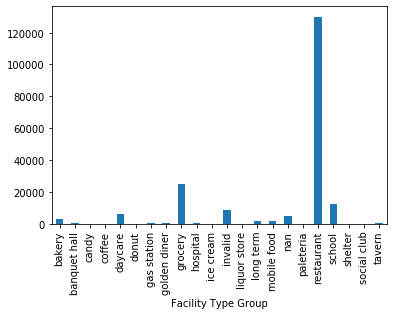

In [278]:
data.groupby('Facility Type Group').count()['DBA Name'].plot.bar()
print("Percentage of invalid facility types: " + str(len(data[data['Facility Type Group'] == 'invalid'])/len(data)*100) + "%")
print("Percentage of nan facility types: " + str(len(data[data['Facility Type Group'] == 'nan'])/len(data)*100) + "%")

We see here that 'restaurant' is the most common facility type. This is good, since we are concerned with restaurants for our research questions. The number of invalid/nan facility types is not too great, so we are satisfied with the result.

## Inspection types
From https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF:

Inspection type: An inspection can be one of the following types: 
* canvass, the most common type of inspection performed at a frequency relative to the risk of the establishment; 
* consultation, when the inspection is done at the request of the owner prior to the opening of the establishment; complaint, when  the inspection is done in response to a complaint against the establishment; 
* license, when the inspection is done as a requirement for the establishment to receive its license to operate; 
* suspect food poisoning, when the inspection is done in response to one or more persons claiming to have gotten ill as a result of eating at the establishment (a specific type of complaint-based inspection); 
* task-force inspection, when an inspection of a bar or tavern is done. 

Re-inspections can occur for most types of these inspections and are indicated as such.

In [284]:
inspection_types = data['Inspection Type'].drop_duplicates().reset_index(drop=True).apply(str)
valid_inspection_types = ['canvass', 'consultation', 'license', 'complaint', 'food poisoning', 'task', 're-inspection']
print(inspection_types[inspection_types.apply(format_string).map(lambda x: any([y in x for y in valid_inspection_types]))])
print(inspection_types[inspection_types.apply(format_string).map(lambda x: not any([y in x for y in valid_inspection_types]))])

0              License Re-Inspection
1            Complaint Re-Inspection
2                            License
3                            Canvass
4              Canvass Re-Inspection
                   ...              
102               SPECIAL TASK FORCE
103             TASK FORCE NOT READY
104      LIQOUR TASK FORCE NOT READY
106           TASK FORCE LIQUOR 1474
108    TASK FORCE PACKAGE GOODS 1474
Name: Inspection Type, Length: 63, dtype: object
5                   Recent Inspection
10                          Not Ready
12                     Non-Inspection
13         Special Events (Festivals)
14                  Recent inspection
16                               FIRE
17                        Tag Removal
18                                nan
23      KITCHEN CLOSED FOR RENOVATION
24                               O.B.
25                  CORRECTIVE ACTION
31                  Illegal Operation
32                Package Liquor 1474
33       TWO PEOPLE ATE AND GOT SICK.
37          

We find that the classification for inspection types is hard. Several inspection types fit more than one group, such as LICENSE TASK FORCE / NOT -FOR-PROFIT CLUB, which could be classified as 'license' and 'task force'. Also, there are many inspection types that are deemed as invalid that could be manually annotated, for example TWO PEOPLE ATE AND GOT SICK could be classified as 'complaint'.

This data is not used right now, but it might be used later when trying to go more in depth. By then, we will refine the method to better accommodate for the difficulties in classification.

## Results
From https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF:

An inspection can pass, pass with conditions or fail. Establishments receiving a ‘pass’ were found to have no critical or serious violations (violation number 1-14 and 15-29, respectively). Establishments receiving a ‘pass with conditions’ were found to have critical or serious violations, but these were corrected during the inspection. Establishments receiving a ‘fail’ were found to have critical or serious violations that were not correctable during the inspection. An establishment receiving a ‘fail’ does not necessarily mean the establishment’s licensed is suspended. Establishments found to be out of business or not located are indicated as such. 

We add the categories 'not ready' and 'no entry', which covers all result types.

In [404]:
results = data['Results'].apply(str)
results_unique = data['Results'].drop_duplicates().reset_index(drop=True).apply(str)
valid_results_strings = ['pass','pass w/ conditions','fail','out of business', 'business not located', 'not ready', 'no entry']
print('Valid results')
print(results_unique[results_unique.apply(str.lower).map(lambda x: any([y == x for y in valid_results_strings]))])
print('Invalid results')
print(results_unique[results_unique.apply(str.lower).map(lambda x: not any([y == x for y in valid_results_strings]))])

Valid results
0                    Fail
1                    Pass
2               Not Ready
3      Pass w/ Conditions
4                No Entry
5         Out of Business
6    Business Not Located
Name: Results, dtype: object
Invalid results
Series([], Name: Results, dtype: object)


We see that the Results column is well-formed, and that we do not have to format it.

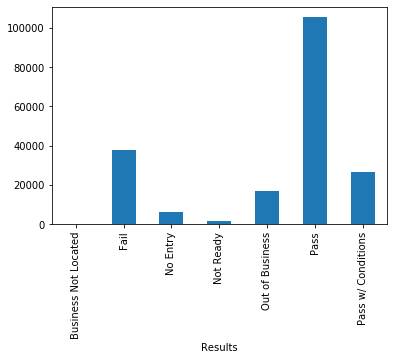

In [163]:
data.groupby('Results').count()['DBA Name'].plot.bar()

## Violations
Violations are interesting in that they contain a lot of data which needs to be parsed to be usable. For example:

In [286]:
data['Violations'][102762]

'18. NO EVIDENCE OF RODENT OR INSECT OUTER OPENINGS PROTECTED/RODENT PROOFED, A WRITTEN LOG SHALL BE MAINTAINED AVAILABLE TO THE INSPECTORS - Comments: OBSERVED EVIDENCE OF LIVE FRUIT FLIES INSIDE PREMISES. OBSERVED LIVE FRUIT FLIES ON WALLS AND CEILING IN BASEMENT. APPROXIMATELY 40 LIVE FRUIT FLIES WERE OBSERVED IN THIS AREAS. MUST CLEAN AND SANITIZE  AFFECTED AREAS. ADDITIONAL PEST CONTROL SERVICE IS NEEDED TO MINIMIZE OR ELIMINATE THE PEST ACTIVITY. SERIOUS VIOLATIOM 7-38-020. | 29. PREVIOUS MINOR VIOLATION(S) CORRECTED 7-42-090 - Comments: PREVIOUS MINOR VIOLATIONS NOT CORRECTED FROM 09/09/13, REPORT#129655833. (33)OBSERVED THE FOLLOWING NOT CLEAN:INTERIOR OF CEILING,WALLS DOOR OF BASEMENT WALK IN COOLER,PREP COOLERS,ESPECIALLY THE HANDLES,DISH MACHINE,ALL FOOD EQUIPMENT ON 1ST FLOOR. 12/09/2013   (35) OPENINGS GOING DOWN WALL BEHIND DOOR LEADING TO BASEMENT.MUST SEAL TO PREVENT HIDING AREAS FOR PEST. SERIOUS VIOLATIONS NOT CORRECTED 7-42-090 | 30. FOOD IN ORIGINAL CONTAINER, PROPE

Violations seem to have the structure:
(&lt;violation number>. &lt;violation title> - &lt;violation comments> - | )+ We create a regex to be able to extract the violation numbers, which can later be used. The other data is not considered at the moment.

According to https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF, critical violations are numbered 1-14, and serious violations are numbered 15-29. If these are found and fixed during the inspection, the inspection will pass with conditions. Otherwise it will fail.

In [288]:
re_num = re.compile(r'([0-9]+)\.\s.*?\s\|')
violation_numbers = data['Violations'].apply(str).apply(re_num.findall).apply(lambda xs: list(map(lambda x: int(x), xs)))
critical_violations = range(1,14+1)
serious_violations = range(15, 29+1)
violation_numbers
# Maybe we can actually connect violation numbers to result "Out of business"
# See under "Under what conditions will a food establishment get shut down?" https://dchealth.dc.gov/service/understanding-food-establishment-inspections
# While this is for Washington DC, I think it could apply to us too
# Also see "Results" in https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF

0                       [3, 5, 25, 50, 53, 53, 56]
1                                               []
2                                               []
3                                         [10, 55]
4                                         [54, 55]
                            ...                   
194899                                          []
194900                            [18, 32, 34, 35]
194901                                          []
194902    [18, 19, 32, 33, 34, 35, 36, 37, 38, 39]
194903                                          []
Name: Violations, Length: 194708, dtype: object

We explode the violation numbers and plot the count of each.

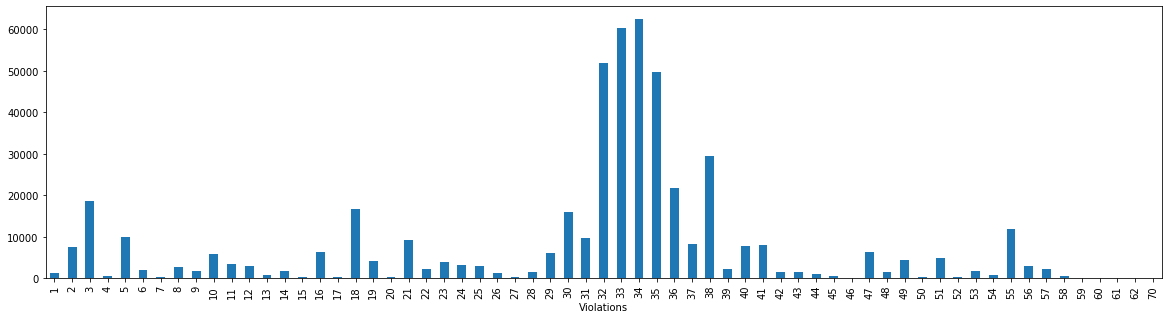

In [290]:
violation_numbers_exploded = violation_numbers.explode().dropna().sort_values()
violation_numbers_exploded.groupby(violation_numbers_exploded).count().plot.bar(figsize=(20,5))

We then map the numbers to their severity.

In [258]:
violations_severity = violation_numbers.apply(lambda xs: list(map(lambda x: 'critical' if x in critical_violations else 'serious' if x in serious_violations else 'non-serious', xs)))
violations_severity = violations_severity.apply(lambda xs: ['no violation'] if len(xs) == 0 else xs)
violations_severity

0         [critical, critical, serious, non-serious, non...
1                                            [no violation]
2                                            [no violation]
3                                   [critical, non-serious]
4                                [non-serious, non-serious]
                                ...                        
194899                                       [no violation]
194900     [serious, non-serious, non-serious, non-serious]
194901                                       [no violation]
194902    [serious, serious, non-serious, non-serious, n...
194903                                       [no violation]
Name: Violations, Length: 194708, dtype: object

We can now plot the counts for different severities.

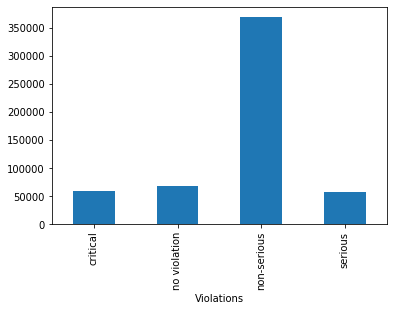

In [253]:
violations_severity_exploded = violations_severity.explode()
violations_severity_exploded.groupby(violations_severity_exploded).count().plot.bar()

We see that most violations are non-serious. T

While this data is quite interesting, we have no need for it right now. However, we might find it interesting while doing a more in-depth analysis for the research questions.

# Supplementing the data

## Income by zip code (actually, anything by zip code if we want)
https://towardsdatascience.com/getting-census-data-in-5-easy-steps-a08eeb63995d

Attribution statement: This product uses the Census Bureau Data API but is not endorsed or certified by the Census Bureau.

Zip code 60666 is the zip code for O'Hare International Airport.
Zip code 60627 is the zip code for Golden Gate Park.
These do not have a household median income since nobody lives there.

In [ ]:
income_by_zip_address = "https://api.census.gov/data/%s/acs/acs5?key=%s&get=%s&for=zip%%20code%%20tabulation%%20area:%s" 
year = "2017" # 2009-2017
api_key = "" # Request here: https://www.census.gov/developers/
income_variable = "B19013_001E"
zip_codes = data['Zip'].drop_duplicates()

for zip_code in zip_codes:
    if pd.isnull(zip_code):
        continue
        
    called_api = income_by_zip_address % (year, api_key, income_variable, int(zip_code))
    response = requests.get(called_api)
    if response.status_code == 200:
        formatted_response = json.loads(response.text)
        print(formatted_response)
    else:
        print('Could not find income for zip code: ' + str(int(zip_code)))
    # add to some list or something, also exception handling
    

In [ ]:
# chicago_map = gpd.read_file('data/chicago_zip.shp') # https://www.kaggle.com/threadid/chicago-shape-files

In [ ]:
# ax = chicago_map.plot()
# g_data.plot(ax=ax, color='red')

# Projecting information on a map

## Coordinates
We want to be able to visualize our dataset on a map based on coordinates. This is done by using Folium.

In [ ]:
data_names = data.groupby('DBA Name').first()
data_names = data_names[data_names['Zip'].apply(pd.isnull)]
print(len(data_names))

In [ ]:
middle_lat = data_names.Latitude.median()
middle_lon = data_names.Longitude.median()
ch_map = folium.Map(location = [middle_lat, middle_lon], zoom_start=10)
locations = folium.map.FeatureGroup()
lats = data_names.Latitude
lons = data_names.Longitude
names = data_names.index


for lat, lon, name in list(zip(lats, lons, names))[0:10]:
    if np.isnan(lat) or np.isnan(lon):
        continue
    folium.Marker(
        location =  [lat, lon],
        tooltip = name,
        icon = folium.Icon(color='green', icon='info-sign')
    ).add_to(ch_map)
    
ch_map.add_child(locations)
print("Done")

## Zip code areas
We use the zip code boundaries in a GeoJSON format from https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-ZIP-Codes/gdcf-axmw. We then simply overlay them on the map.

In [ ]:
ch_map = folium.Map(location = [middle_lat, middle_lon], zoom_start=10)

data_zip = data.groupby('Zip').count().reset_index()[['Zip', 'Risk']].rename(columns={'Risk':'Count'})
data_zip['Zip'] = data_zip['Zip'].apply(int).apply(str)
map_zip = gpd.read_file('data/chicago_zip.geojson')
map_zip = map_zip.merge(data_zip, left_on='zip', right_on='Zip')
zip_geojson = folium.GeoJson(map_zip)

ch_choropleth = folium.Choropleth(
    geo_data=map_zip,
    name='choropleth',
    data=data_zip,
    columns=['Zip', 'Count'],
    key_on='feature.properties.zip',
    fill_color='BuPu',
    fill_opacity=0.7,
    line_opacity=0.5,
    legend_name='Number of inspections per Zip',
)

folium.GeoJsonTooltip(["Count"]).add_to(ch_choropleth.geojson)

ch_choropleth.add_to(ch_map)

#folium.LayerControl().add_to(ch_map)
ch_map

# Research Q2: Restaurant chains vs small businesses

In [233]:
def format_string(s): 
    return re.sub(r'[^a-z0-9ì]+', '', str.lower(s)) # ì is for the chain Così

In [234]:
def group_type_from_string(types, strings):
    group = types.apply(format_string).map(lambda x: functools.reduce(lambda acc,b: b if x.startswith(b) else acc, strings, 'invalid'))
    return group

## Find relevant rows in the dataset
We are interested in just the restaurants. However, there are some chains which are classified as both restaurants and another facility type. For example, Dunkin' Donuts are classified as both restaurant, bakery, donut and nan. We can see a similar problem affecting McDonalds.

In [235]:
data[data['DBA Name'].apply(format_string) == 'dunkindonuts'].groupby('Facility Type Group').count()

,Inspection ID,DBA Name,Facility Type,Risk,Address,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Year
Facility Type Group,,,,,,,,,,,,,
bakery,8,8,8,8,8,8,8,8,8,8,8,8,8
donut,8,8,8,8,8,8,8,8,8,8,8,8,8
nan,20,20,0,19,20,20,20,20,20,20,20,20,20
restaurant,1433,1433,1433,1433,1433,1433,1433,1433,1433,1433,1416,1416,1433


In [236]:
data[data['DBA Name'].apply(format_string) == 'mcdonalds'].groupby('Facility Type Group').count()

,Inspection ID,DBA Name,Facility Type,Risk,Address,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Year
Facility Type Group,,,,,,,,,,,,,
nan,20,20,0,20,20,20,20,20,20,20,20,20,20
restaurant,1360,1360,1360,1360,1360,1360,1360,1360,1360,1360,1360,1360,1360


We want to keep data loss to a minimum, therefor we decide to classify bakery, banquet hall, candy, coffee, donut, golden diner, ice cream, mobile food, nan, paleteria and tavern as restaurants, as we assume that these facility types can serve food, and could be counted as restaurants by an inspector. Note that nan is kind of a catch-all, and that things that are not restaurants may be included. 

In [237]:
restaurant_equiv = ['restaurant', 'bakery', 'banquet hall', 'candy', 'coffee', 'donut', 'golden diner', 'ice cream', 'mobile food', 'nan', 'paleteria', 'tavern']
facility_type_group2 = group_type_from_string(facility_type_group, restaurant_equiv)
data.loc[:,'Facility Type Group'] = facility_type_group2
data = data[data['Facility Type Group'] != 'invalid']
data

,Inspection ID,DBA Name,Facility Type,Risk,Address,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Facility Type Group,Year
0,2320509.0,TAQUERIA EL DORADO,Restaurant,Risk 1 (High),2114 W LAWRENCE AVE,60625.0,2019-10-25T00:00:00.000,License Re-Inspection,Fail,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.968820,-87.682292,restaurant,2019
1,2320519.0,SALAM RESTAURANT,Restaurant,Risk 1 (High),4634-4636 N KEDZIE AVE,60625.0,2019-10-25T00:00:00.000,Complaint Re-Inspection,Pass,No Violation,41.965719,-87.708538,restaurant,2019
2,2320421.0,THE NEW GRACE RESTAURANT,Restaurant,Risk 1 (High),4409 N BROADWAY,60640.0,2019-10-24T00:00:00.000,License,Not Ready,No Violation,41.962104,-87.655204,restaurant,2019
5,2320442.0,CHOI'S CHINESE KITCHEN,Restaurant,Risk 1 (High),2638 N MILWAUKEE AVE,60647.0,2019-10-24T00:00:00.000,Canvass,Pass,37. FOOD PROPERLY LABELED; ORIGINAL CONTAINER ...,41.929670,-87.708624,restaurant,2019
6,2320427.0,HARMONY RESTAURANT,Restaurant,Risk 1 (High),6525 W ARCHER AVE,60638.0,2019-10-24T00:00:00.000,Complaint Re-Inspection,Fail,"38. INSECTS, RODENTS, & ANIMALS NOT PRESENT - ...",41.792164,-87.785406,restaurant,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194899,67732.0,WOLCOTT'S,Restaurant,Risk 1 (High),1834 W MONTROSE AVE,60613.0,2010-01-04T00:00:00.000,License Re-Inspection,Pass,No Violation,41.961606,-87.675967,restaurant,2010
194900,67738.0,MICHAEL'S ON MAIN CAFE,Restaurant,Risk 1 (High),8750 W BRYN WAWR AVE,60631.0,2010-01-04T00:00:00.000,License,Fail,18. NO EVIDENCE OF RODENT OR INSECT OUTER OPEN...,NaN,NaN,restaurant,2010
194901,70269.0,mr.daniel's,Restaurant,Risk 1 (High),5645 W BELMONT AVE,60634.0,2010-01-04T00:00:00.000,License Re-Inspection,Pass,No Violation,41.938443,-87.768318,restaurant,2010
194902,104236.0,TEMPO CAFE,Restaurant,Risk 1 (High),6 E CHESTNUT ST,60611.0,2010-01-04T00:00:00.000,Canvass,Fail,18. NO EVIDENCE OF RODENT OR INSECT OUTER OPEN...,41.898431,-87.628009,restaurant,2010


In [238]:
data.loc[:,'Year'] = data['Inspection Date'].apply(lambda x: int(x[0:4])).copy()
data

,Inspection ID,DBA Name,Facility Type,Risk,Address,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Facility Type Group,Year
0,2320509.0,TAQUERIA EL DORADO,Restaurant,Risk 1 (High),2114 W LAWRENCE AVE,60625.0,2019-10-25T00:00:00.000,License Re-Inspection,Fail,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.968820,-87.682292,restaurant,2019
1,2320519.0,SALAM RESTAURANT,Restaurant,Risk 1 (High),4634-4636 N KEDZIE AVE,60625.0,2019-10-25T00:00:00.000,Complaint Re-Inspection,Pass,No Violation,41.965719,-87.708538,restaurant,2019
2,2320421.0,THE NEW GRACE RESTAURANT,Restaurant,Risk 1 (High),4409 N BROADWAY,60640.0,2019-10-24T00:00:00.000,License,Not Ready,No Violation,41.962104,-87.655204,restaurant,2019
5,2320442.0,CHOI'S CHINESE KITCHEN,Restaurant,Risk 1 (High),2638 N MILWAUKEE AVE,60647.0,2019-10-24T00:00:00.000,Canvass,Pass,37. FOOD PROPERLY LABELED; ORIGINAL CONTAINER ...,41.929670,-87.708624,restaurant,2019
6,2320427.0,HARMONY RESTAURANT,Restaurant,Risk 1 (High),6525 W ARCHER AVE,60638.0,2019-10-24T00:00:00.000,Complaint Re-Inspection,Fail,"38. INSECTS, RODENTS, & ANIMALS NOT PRESENT - ...",41.792164,-87.785406,restaurant,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194899,67732.0,WOLCOTT'S,Restaurant,Risk 1 (High),1834 W MONTROSE AVE,60613.0,2010-01-04T00:00:00.000,License Re-Inspection,Pass,No Violation,41.961606,-87.675967,restaurant,2010
194900,67738.0,MICHAEL'S ON MAIN CAFE,Restaurant,Risk 1 (High),8750 W BRYN WAWR AVE,60631.0,2010-01-04T00:00:00.000,License,Fail,18. NO EVIDENCE OF RODENT OR INSECT OUTER OPEN...,NaN,NaN,restaurant,2010
194901,70269.0,mr.daniel's,Restaurant,Risk 1 (High),5645 W BELMONT AVE,60634.0,2010-01-04T00:00:00.000,License Re-Inspection,Pass,No Violation,41.938443,-87.768318,restaurant,2010
194902,104236.0,TEMPO CAFE,Restaurant,Risk 1 (High),6 E CHESTNUT ST,60611.0,2010-01-04T00:00:00.000,Canvass,Fail,18. NO EVIDENCE OF RODENT OR INSECT OUTER OPEN...,41.898431,-87.628009,restaurant,2010


## Categorizing the data
We use the list of US restaurant chains found here: https://en.wikipedia.org/wiki/List_of_restaurant_chains_in_the_United_States, which we convert to CSV using the tool here: https://wikitable2csv.ggor.de/.

In [239]:
restaurant_chains = pd.read_csv('data/restaurant_chains.csv')
restaurant_chains

,Name,Original location,Year started,Head office location,Number of worldwide locations,Areas served,Notes
0,Jollibee,"Quezon City, Philippines",1978,"Quezon City, Philippines","1,200","West, Mid-Atlantic, Hawaii",NaN
1,L&L Hawaiian Barbecue,"Honolulu, Hawaii",1976,"Honolulu, Hawaii",200+,"West, Southeast, New York, Hawaii, Alaska",NaN
2,Manchu Wok,"Peterborough, Ontario, Canada",1980,"Markham, Ontario, Canada",101,Nationwide,NaN
3,Noodles & Company,"Denver, Colorado",1995,"Broomfield, Colorado",460,Nationwide,NaN
4,Panda Express,"Glendale, California",1983,"Rosemead, California","2,000+",Nationwide,NaN
...,...,...,...,...,...,...,...
388,Sizzler,"Culver City, California",1958,"Mission Viejo, California",270,NaN,NaN
389,Western Sizzlin',"Augusta, Georgia",1962,"Roanoke, Virginia",54,NaN,NaN
390,Chuck E. Cheese's,"San Jose, California",1977,"Irving, Texas",608,Nationwide,NaN
391,Dave & Busters,"Dallas, Texas",1982,"Dallas, Texas",134,Nationwide,NaN


In [240]:
restaurant_chains_names = restaurant_chains['Name'].apply(format_string)
data_w_chain = data.copy()
data_w_chain['Chain'] = group_type_from_string(data_w_chain['DBA Name'], restaurant_chains_names)

For the restaurant chains, we assume a match with 'nan' as facility type group corresponds to a restaurant.

In [241]:
data_chains = data_w_chain[data_w_chain['Chain'] != 'invalid']
data_chains

,Inspection ID,DBA Name,Facility Type,Risk,Address,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Facility Type Group,Year,Chain
9,2320383.0,ARGO TEA,Restaurant,Risk 1 (High),11601 W TOUHY AVE,60666.0,2019-10-24T00:00:00.000,Canvass Re-Inspection,Pass,47. FOOD & NON-FOOD CONTACT SURFACES CLEANABLE...,42.008536,-87.914428,restaurant,2019,argotea
26,2320374.0,DUNKIN DONUTS/BASKIN ROBBINS,Restaurant,Risk 2 (Medium),6925 S PULASKI RD,60629.0,2019-10-24T00:00:00.000,Complaint Re-Inspection,Fail,"38. INSECTS, RODENTS, & ANIMALS NOT PRESENT - ...",41.766871,-87.722317,restaurant,2019,dunkindonuts
58,2320265.0,DOMINO'S PIZZA,Restaurant,Risk 2 (Medium),5016 S PULASKI RD,60632.0,2019-10-22T00:00:00.000,Canvass,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.801787,-87.723555,restaurant,2019,dominos
86,2320281.0,DUNKIN DONUTS,Restaurant,Risk 2 (Medium),201 W MADISON ST,60606.0,2019-10-22T00:00:00.000,License,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.881835,-87.633897,restaurant,2019,dunkindonuts
93,2316196.0,MCDONALD'S RESTAURANT,Restaurant,Risk 1 (High),11601 W TOUHY AVE,60666.0,2019-10-21T00:00:00.000,Canvass,Pass,36. THERMOMETERS PROVIDED & ACCURATE - Comment...,42.008536,-87.914428,restaurant,2019,mcdonalds
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194852,80208.0,Dunkin Donuts,Restaurant,Risk 1 (High),2800 W Lawrence AVE BLDG,60625.0,2010-01-05T00:00:00.000,License,Fail,18. NO EVIDENCE OF RODENT OR INSECT OUTER OPEN...,41.968641,-87.698725,restaurant,2010,dunkindonuts
194868,114256.0,STARBUCKS COFFEE #13710,Restaurant,Risk 2 (Medium),30 W ERIE ST,60654.0,2010-01-05T00:00:00.000,Canvass,Pass,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.894165,-87.629389,restaurant,2010,starbucks
194873,164254.0,POPEYES CHICKEN,Restaurant,Risk 1 (High),7250 S WESTERN AVE,60636.0,2010-01-05T00:00:00.000,Short Form Complaint,Pass,33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSI...,41.761369,-87.683297,restaurant,2010,popeyes
194891,158243.0,DUNKIN DONUTS,Restaurant,Risk 2 (Medium),970 W PERSHING RD,60609.0,2010-01-05T00:00:00.000,License,Fail,No Data,41.823504,-87.650666,restaurant,2010,dunkindonuts


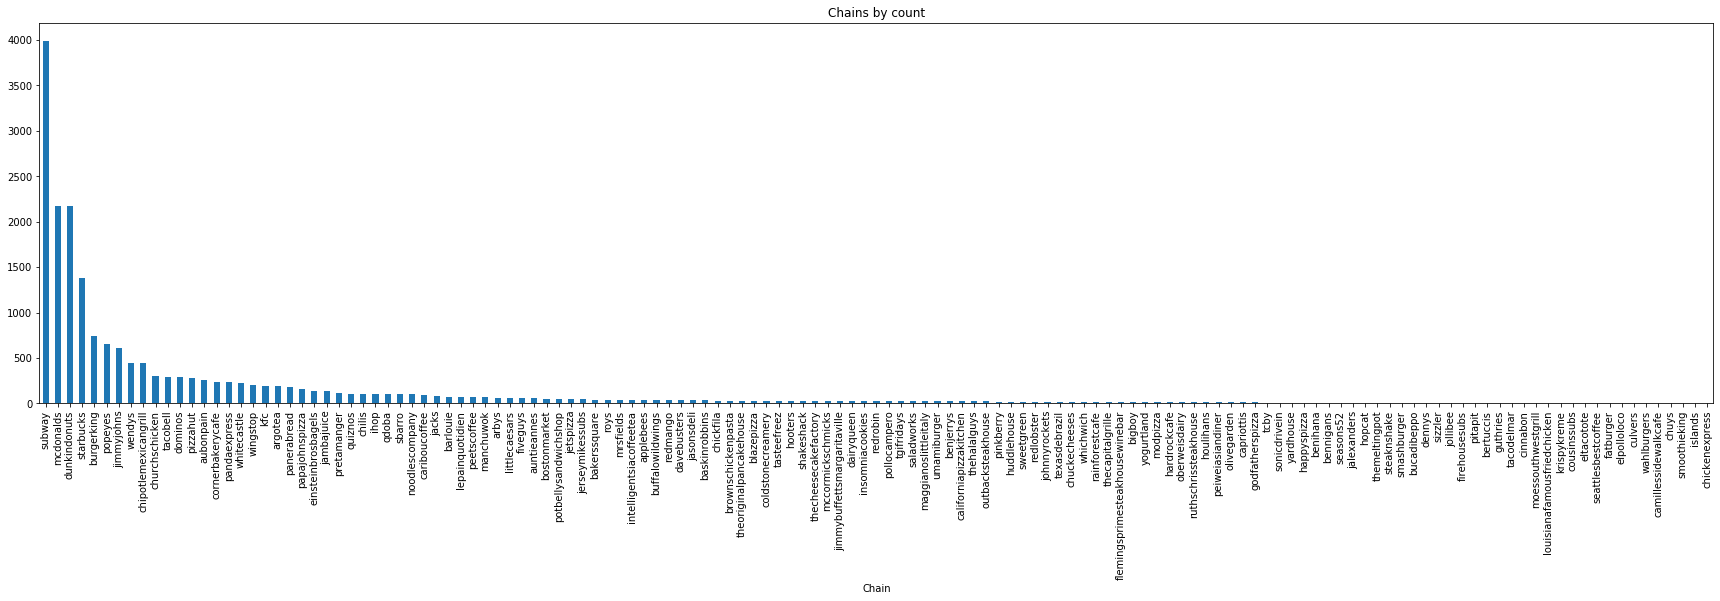

In [242]:
data_chains.groupby('Chain').count()['DBA Name'].sort_values(ascending=False).plot.bar(title='Chains by count',figsize=(30,7))

We have a problem with chain names like "Jack's" and "Roy's", since these are actual names, which can match with longer small business names. For example, "JACK'S FISH CHICKEN & MORE" is classified as "Jack's" for containing the name, but it has no association with the franchise "Jack's. 

In [262]:
data_chains[data_chains['Chain'] == 'chilis']


,Inspection ID,DBA Name,Facility Type,Risk,Address,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Facility Type Group,Year,Chain
676,2315297.0,CHILI'S T - 3,Restaurant,Risk 1 (High),11601 W TOUHY AVE,60666.0,2019-10-03T00:00:00.000,Canvass Re-Inspection,Pass,47. FOOD & NON-FOOD CONTACT SURFACES CLEANABLE...,42.008536,-87.914428,restaurant,2019,chilis
681,2315324.0,Chili's- G Concourse,Restaurant,Risk 1 (High),11601 W TOUHY AVE,60666.0,2019-10-03T00:00:00.000,Canvass,Pass,36. THERMOMETERS PROVIDED & ACCURATE - Comment...,42.008536,-87.914428,restaurant,2019,chilis
936,2312972.0,CHILI'S T - 3,Restaurant,Risk 1 (High),11601 W TOUHY AVE,60666.0,2019-09-26T00:00:00.000,Canvass,Fail,16. FOOD-CONTACT SURFACES: CLEANED & SANITIZED...,42.008536,-87.914428,restaurant,2019,chilis
6524,2290772.0,CHILI'S T - 3,Restaurant,Risk 1 (High),11601 W TOUHY AVE,60666.0,2019-05-31T00:00:00.000,Canvass,Pass w/ Conditions,10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLI...,42.008536,-87.914428,restaurant,2019,chilis
7511,2288739.0,CHILI'S GRILL & BAR,Restaurant,Risk 1 (High),1750 W 119TH ST,60643.0,2019-05-13T00:00:00.000,Complaint,Pass,36. THERMOMETERS PROVIDED & ACCURATE - Comment...,41.677567,-87.665845,restaurant,2019,chilis
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181436,114557.0,CHILI'S GRILL & BAR,Restaurant,Risk 1 (High),2 E ONTARIO ST,60611.0,2010-09-27T00:00:00.000,Canvass,Pass,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.893383,-87.628054,restaurant,2010,chilis
181814,397213.0,CHILI'S T - 3,Restaurant,Risk 1 (High),11601 W TOUHY AVE,60666.0,2010-09-21T00:00:00.000,Complaint,Pass w/ Conditions,7. WASH AND RINSE WATER: CLEAN AND PROPER TEMP...,42.008536,-87.914428,restaurant,2010,chilis
184747,397207.0,Chili's- G Concourse,Restaurant,Risk 1 (High),11601 W TOUHY AVE,60666.0,2010-07-29T00:00:00.000,Canvass,Pass,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,42.008536,-87.914428,restaurant,2010,chilis
184898,277754.0,CHILI'S GRILL & BAR,Restaurant,Risk 1 (High),1750 W 119TH ST,60643.0,2010-07-27T00:00:00.000,Canvass,Pass,33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSI...,41.677567,-87.665845,restaurant,2010,chilis


For small businesses, we pick all the rows that has not been classified as a chain. Here, we do _not_ assume the 'nan' as the facility group type corresponds to a restaurant, and therefore we leave them out.

In [250]:
data_small_business = data_w_chain[data_w_chain['Chain'] == 'invalid']
data_small_business = data_small_business[data_small_business['Facility Type Group'] != 'nan']

## Results

We group the datasets by inspection results, count them, and dividing them by their length to see what the distribution of the results are.  

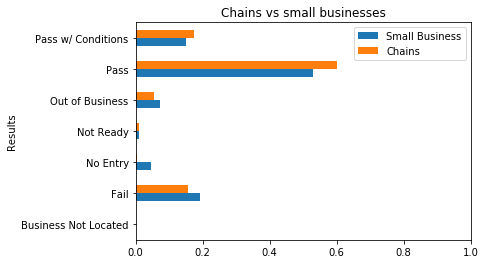

In [251]:
dsb_size = len(data_small_business)
dc_size = len(data_chains)
results_vs = pd.DataFrame()
results_vs['Small Business'] = data_small_business.groupby('Results').count()['DBA Name'].apply(lambda x: x/dsb_size)
results_vs['Chains'] = data_chains.groupby('Results').count()['DBA Name'].apply(lambda x: x/dc_size)
ax = plt.gca()
ax.set_xlim(0,1)
results_vs.plot.barh(title='Chains vs small businesses', ax=ax)

#fig, ax_list = plt.subplots(4,3, figsize=(30,20))
#
# for i, year in enumerate(data['Year'].sort_values().unique()):
#     ax = ax_list[int(i/3)][i%3]
#     ax.set_xlim(0,1)
#     results_vs = pd.DataFrame()
#     dsb_size = len(data_small_business[data_small_business['Year'] == year])
#     dc_size = len(data_chains[data_chains['Year'] == year])
#     results_vs['Small Business'] = data_small_business[data_small_business['Year'] == year].groupby('Results').count()['DBA Name'].apply(lambda x: x/dsb_size)
#     results_vs['Chains'] = data_chains[data_chains['Year'] == year].groupby('Results').count()['DBA Name'].apply(lambda x: x/dc_size)
#     results_vs.plot.barh(title=year, ax=ax)

As we can see, chains generally pass inspections more often than small businesses, and fail less often.

We quantize a bit by setting "Pass" as both "Pass" and "Pass w/ Conditions", and "Fail" as "Fail". The other rows are not connected to the safety of the establishment, so we ignore those for now.

Pass: Chains/Small businesses: 1.0675566199170632


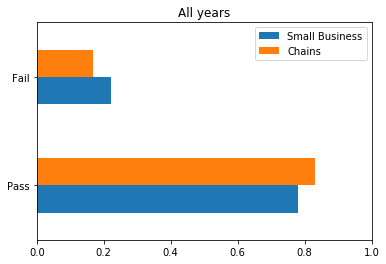

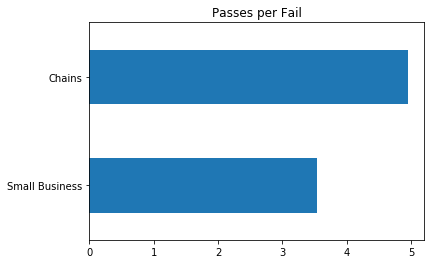

In [252]:
dsb_size = len(data_small_business)
dc_size = len(data_chains)
results_percentage = pd.DataFrame(columns=['Small Business', 'Chains'])
results_percentage.loc['Pass'] = results_vs.loc['Pass']+results_vs.loc['Pass w/ Conditions']
results_percentage.loc['Fail'] = results_vs.loc['Fail']
results_percentage = results_percentage.div(results_percentage.sum(axis=0), axis=1)
plt.figure(0)
ax = plt.gca()
ax.set_xlim(0,1)
results_percentage.plot.barh(title='All years', ax=ax)
plt.figure(1)
passes_per_fail = results_percentage.loc['Pass']/results_percentage.loc['Fail']
passes_per_fail.plot.barh(title='Passes per Fail')
print("Pass: Chains/Small businesses: " + str(results_percentage.loc['Pass']['Chains']/results_percentage.loc['Pass']['Small Business']))


Our measurement tells us that chains are about 7\% safer than small businesses.

## Comparison to Q1

We plot the number of chains per small business on the Chicago map to see how they are distributed.

In [ ]:
middle_lat = data_small_business.Latitude.median()
middle_lon = data_small_business.Longitude.median()

ch_map = folium.Map(location = [middle_lat, middle_lon], zoom_start=10)
data_zip_chains = data_chains.groupby(['Zip', 'Address']).first().reset_index()[['Zip', 'DBA Name']].groupby('Zip').count().rename(columns={'DBA Name':'Count C'})
data_zip_sb = data_small_business.groupby(['Zip', 'Address']).first().reset_index()[['Zip', 'DBA Name']].groupby('Zip').count().rename(columns={'DBA Name':'Count SB'})
data_zip = data_zip_sb.join(data_zip_chains, how='outer')
data_zip['Chain per small business'] = data_zip['Count C']/data_zip['Count SB']
data_zip = data_zip.fillna(0)
data_zip = data_zip.reset_index()
data_zip['Zip'] = data_zip['Zip'].apply(int).apply(str)
map_zip = gpd.read_file('data/chicago_zip.geojson')
map_zip = map_zip.merge(data_zip, left_on='zip', right_on='Zip')
zip_geojson = folium.GeoJson(map_zip)

ch_choropleth = folium.Choropleth(
    geo_data=map_zip,
    name='choropleth',
    data=data_zip,
    columns=['Zip', 'Chain per small business'],
    key_on='feature.properties.zip',
    fill_color='Reds',
    fill_opacity=0.7,
    line_opacity=0.5,
    legend_name='Chain per small business per zip code',
)

folium.GeoJsonTooltip(["Chain per small business", "Zip"]).add_to(ch_choropleth.geojson)

ch_choropleth.add_to(ch_map)

#folium.LayerControl().add_to(ch_map)
ch_map

## What comes next?

* We would like to see our results on a yearly basis instead of an aggregated result which we have now. With interactive plots and maps, we will add a slider which will be used to select year.
* We would like to connect the results of Q1 and Q2, where the differences in Q2 could be explained by the results of Q1.
* We will make a conclusion out of our results, and then choose the appropriate plots and maps to use for the poster.